---
title: Telecommunication towers component clasification. Part 3. PyTorch and miniai  
author: "Francisco Mussari"  
date: 2023-03-06  
image: ""  
categories: [deeplearning, dataloaders, API, transforms, Walk with fastai, PyTorch, fastai]  
format:
  html:
    toc: true
    toc-depth: 3
    
---

## Introduction
This is the third part of a series of posts dedicated to image classification of components that are pats of telecommunication structures.

In **Part 1** we used all the magic of fastai directly, blindly, as was introduced in the firsts lessons of [Practical Deep Learning for Coders](https://course.fast.ai/):  

- [Telecommunication towers component clasification - Part 1. fastai](./Part_1__Tower_Parts_Classisfier_with_fastai.ipynb)  

In **Part 2** the idea was to apply the lessons from the course [Walk with fastai, the missing pieces for success](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html). It meant to get rid of the fastai magic except for the training, and use raw PyTorch for the dataset and dataloader creation and model setup.  

- [Telecommunication towers component clasification. Part 2. PyTorch](./Part_2__Wwf_Homework_PyTorch_Tower_Classification.ipynb)  

Here we are going to use miniai, which is a simple and flexible framework that is being developed in Part 2 of Practical Deep Learning for Coders 2022. To install the framework go to: https://github.com/fastai/course22p2.

## Import Libraries

In [ ]:
from pathlib import Path

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import torch
import torchvision.transforms as tvtfms

from PIL import Image

import pandas as pd
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt

## Image Data

There are 514 images (training + validation) in 8 relatively "easy" to distinguish categories (components). Plus there are 20 images for testing.

- Base plate
- Grounding bar
- Identification
- Ladder
- Light
- Lightning rod
- Platform
- Transmission lines

You can download the pictures [here](https://drive.google.com/open?id=1Prtb9VbTau8Zk4c4K0YGFfL98MsGuf-F).
 
There are two folders, one for the training (train) and the other for validation set (valid).

In [ ]:
path = Path("photos")
[folder.stem for folder in path.iterdir()]

['test', 'train', 'valid']

In [ ]:
train_path = path / "train"
valid_path = path / "valid"
test_path = path / "test"

And in each folder there is one folder for each label.

In [ ]:
labels = [folder.stem for folder in train_path.iterdir()]
number_of_labels = len(labels)
print(labels)

['base_plate', 'grounding_bar', 'identification', 'ladder', 'light', 'lightning_rod', 'platform', 'transmission_lines']


In [ ]:
int_to_label = {k:v for k,v in enumerate(labels)}
label_to_int = {k:v for v,k in int_to_label.items()}
print(label_to_int)

{'base_plate': 0, 'grounding_bar': 1, 'identification': 2, 'ladder': 3, 'light': 4, 'lightning_rod': 5, 'platform': 6, 'transmission_lines': 7}


## Creating PyTorch Dataset

### Dataset Class

This class is based in the amazing [Walk with fastai course](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html) whose [Using Raw PyTorch]() lesson has the following note in the Dataset code.

> This example is highly based on the work of Sylvain Gugger
for the Accelerate notebook example which can be found here: 
https://github.com/huggingface/notebooks/blob/main/examples/accelerate_examples/simple_cv_example.ipynb

In [ ]:
class TowerPartsDataset(Dataset):
    def __init__(self, path:Path, transforms:nn.Sequential, label_to_int:dict):
        self.transforms = transforms
        self.paths = [f for folder in path.iterdir() for f in folder.iterdir()]
        self.to_tensor = tvtfms.ToTensor()
    
    def __len__(self):
        return len(self.paths)
    
    def apply_x_transforms(self, filepath):
        image = Image.open(filepath)#.convert("RGB")
        tensor_image = self.to_tensor(image)
        return self.transforms(tensor_image)
    
    def apply_y_transforms(self, filepath):
        label = filepath.parent.name
        return label_to_int[label]
    
    def __getitem__(self, index):
        filepath = self.paths[index]
        x = self.apply_x_transforms(filepath)
        y = self.apply_y_transforms(filepath)
        return (x, y)

### Item Transforms

In [ ]:
from fastai.vision.data import imagenet_stats
print(imagenet_stats)

item_tfms = nn.Sequential(
    tvtfms.Resize((224, 224)), 
    tvtfms.Normalize(*imagenet_stats)
)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


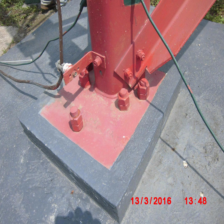

In [ ]:
item_tfms[0](Image.open(train_path / 'base_plate/CIMG4695.jpg'))

### Train and validation datasets

In [ ]:
train_dataset = TowerPartsDataset(
    train_path,
    item_tfms,
    label_to_int
)

valid_dataset = TowerPartsDataset(
    valid_path,
    item_tfms,
    label_to_int
)

In [ ]:
x, y = train_dataset[0]
x.shape, y

(torch.Size([3, 224, 224]), 0)

## DataLoader

In [ ]:
batch_size = 64

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    drop_last=True,
    batch_size=batch_size
)

In [ ]:
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size * 2
)

### miniai `Dataloaders`

In [ ]:
from miniai.datasets import DataLoaders, show_images

In [ ]:
dls = DataLoaders(train_dataloader, valid_dataloader)

In [ ]:
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([64, 3, 224, 224]), tensor([6, 7, 0, 0, 2, 6, 6, 6, 3, 5]))

In [ ]:
%%time
for _ in train_dataloader: pass

CPU times: user 6min 35s, sys: 49.7 s, total: 7min 25s
Wall time: 1min 25s


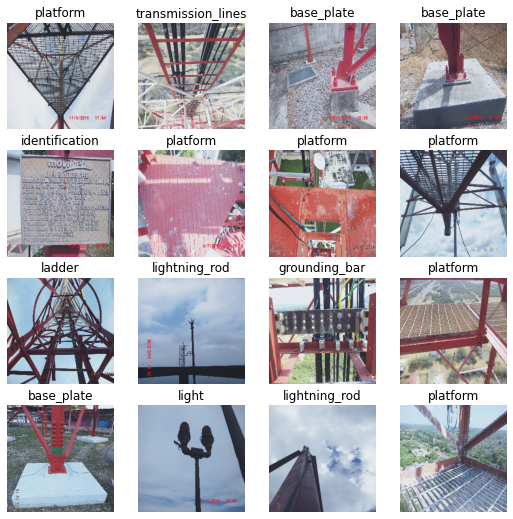

In [ ]:
from operator import itemgetter

# To avoid warning of clipping input data, a sigmoid is applied
xbt = xb[:16].sigmoid()
ybt = yb[:16]
titles = itemgetter(*ybt.tolist())(int_to_label)
show_images(xbt, imsize=2.25, titles=titles)

As we can see, there are some pictures that have at least two components that could be classified as for our labels. So maybe the correct approach would be a multi-label classification.

##  Customizing a PyTorch Model

When loading a model to fastai learner, it is customized by changing the last two children (the Head).   

What we are going to do here is to change only what is essential for our problem, that is, the final linear layer in order to have 8 features (the number of labels need to classify).  

For more detail on this I encourage you to take [Walk with fastai, the missing pieces for success](https://muellerzr.github.io/fastblog/2022/10/22/Walkwithfastai.html).  

Unlike Part 1 and Part 2, here we are going to try with `resnet18`.

In [ ]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)

### Customizing the last linear layer
We need an output size equal to the number of labels we are trying to predict.

In [ ]:
model_child = list(model.children())
model_child[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

We can access the original final layer with `model.fc`

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

It has the 1,000 features ResNet was trained for. We need to change it to the 8 features (labels, classes) of the problem we are dealing here:

In [ ]:
model.fc = nn.Linear(512, out_features=number_of_labels, bias=True)

In [ ]:
model.fc

Linear(in_features=512, out_features=8, bias=True)

## Callbacks
For more info about miniai and its callback system: 
- [Fastai Course Part 2 2022: Understanding CallBacks](https://francescopochetti.com/fastai-course-part-2-2022-understanding-callbacks/) by Francesco Pochetti
- [Redesign your Training Loop with CallBacks](https://dienhoa.github.io/dhblog/posts/Learner.html)

In [ ]:
from miniai.learner import MetricsCB, DeviceCB, ProgressCB, TrainLearner
from torcheval.metrics import MulticlassAccuracy

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## The Optimizer

Let's use the same optimizer as fastai's default: `AdamW`

In [ ]:
from miniai.activations import set_seed
from miniai.sgd import BatchSchedCB, RecorderCB

from torch.optim import AdamW
from functools import partial
from torch.optim import lr_scheduler
import torch.nn.functional as F

### Record the scheduler's parameters

In [ ]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]

rec = RecorderCB(lr=_lr, mom=_beta1)

## Training with miniai

In [ ]:
set_seed(42)
lr, epochs = 0.001, 4

### Custom training loop

miniai callbacks allows us to easily modify the training loop. In this case we are going to store the validation loss for each sample of the validation dataset (without reducing it to a single value). Since the validation set has 120 pictures, and the validation batch size is 64 x 2, by storing the last loss as `valid_loss` is enough to then use those values and plot the top losses as we do with fastai. 

Predictions are stored in `learn.preds` as set in  miniai `TrainLearner`.

In [ ]:
class TrainValidLossTrack(TrainLearner):
    def get_loss(self): 
        self.loss = self.loss_func(self.preds, self.batch[1])
        # Store loss without reduction in the Learner
        self.valid_loss = self.loss_func(self.preds, self.batch[1], reduction="none")

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

xtra = [BatchSchedCB(sched), rec]
learn = TrainValidLossTrack(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=AdamW)

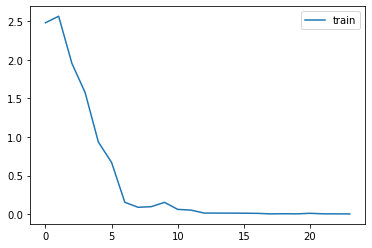

In [ ]:
learn.fit(epochs)

Good news, it trained better than (I) expected! It looks like it overfit a little, although we only trained for 4 epochs and a smaller model (resnet18) vs Part 1 & 2 (resnet34).

### How the the parameters were changed by the scheduler

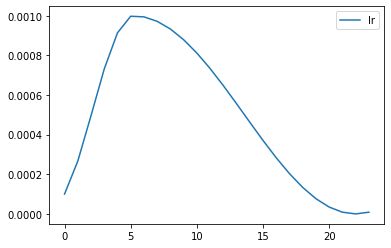

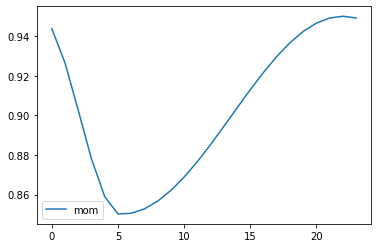

In [ ]:
import matplotlib.pyplot as plt
rec.plot()

## Classification Interpretation

In [ ]:
learn.preds.shape, learn.valid_loss.shape

(torch.Size([120, 8]), torch.Size([120]))

In [ ]:
actuals = [label_to_int[l.parts[-2]] for l in valid_dataset.paths]

### Confusion Matrix

In [ ]:
confusion_matrix = [[0]*number_of_labels for n in range(number_of_labels)]
act_pred = list(zip(actuals, learn.preds.argmax(1).tolist()))

for act, pred in act_pred:
    confusion_matrix[act][pred] += 1

In [ ]:
x = y = [x for x in labels]

fig = px.imshow(confusion_matrix, labels=dict(x="Predicted", y="Actual", color="# Pics"),
                text_auto=True, x=x, y=x,
                color_continuous_scale='blues', title='Confusion Matrix')
fig.show()

### Plot Top Losses

In [ ]:
sorted_losses_idcs = learn.valid_loss.argsort(descending=True).cpu()

In [ ]:
dv = dls.valid
xb, yb = next(iter(dv))
xbv = xb[sorted_losses_idcs[:12]].sigmoid()

In [ ]:
act_pred_plot = torch.tensor(act_pred)[sorted_losses_idcs[:12]].tolist()

In [ ]:
titles = [f"{int_to_label[act]} / \n {int_to_label[pred]}" for act, pred in act_pred_plot][:12]

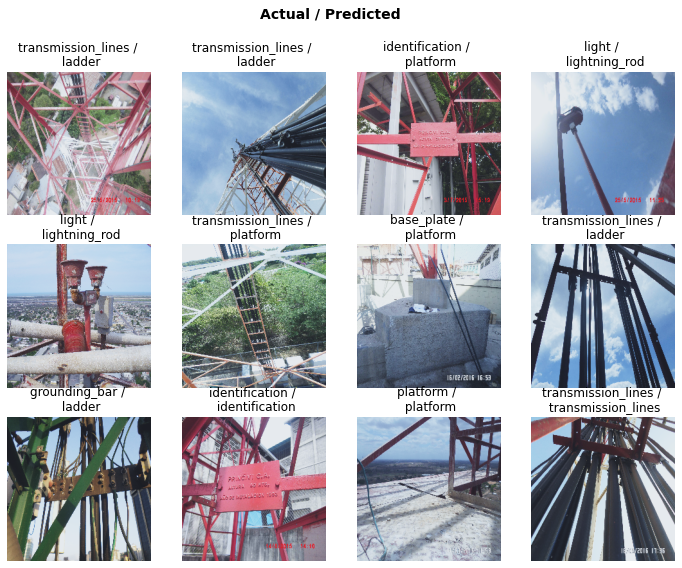

In [ ]:
show_images(xbv, imsize=3.0, title='Actual / Predicted', titles=titles)

## Save the model

In [ ]:
mdl_path = Path('models')
torch.save(learn.model,  mdl_path/'exported_resnet18_pytorch-miniai.pth')

## GPU Inference

In [ ]:
loaded_model = torch.load(mdl_path/'exported_resnet18_pytorch-miniai.pth')

### model evaluation
> _Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference._ 

https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models

In [ ]:
loaded_model.eval();

### Test dataset

In [ ]:
test_files = list(test_path.iterdir())
print(test_files)

[Path('photos/test/archipielago-los-roques-078.jpg'), Path('photos/test/archipielago-los-roques-313.jpg'), Path('photos/test/cantv-mata-palo-350.jpg'), Path('photos/test/CIMG8119.jpg'), Path('photos/test/DSC00191.jpg'), Path('photos/test/DSC01399.jpg'), Path('photos/test/DSC01537.jpg'), Path('photos/test/DSC01628.jpg'), Path('photos/test/DSC01657.jpg'), Path('photos/test/DSC01723.jpg'), Path('photos/test/DSC01734.jpg'), Path('photos/test/DSC01955.jpg'), Path('photos/test/DSC01956.jpg'), Path('photos/test/DSC04892.jpg'), Path('photos/test/DSC05105.jpg'), Path('photos/test/DSC05130.jpg'), Path('photos/test/DSC09446.jpg'), Path('photos/test/DSC09524.jpg'), Path('photos/test/DSC09685.jpg'), Path('photos/test/DSC09908.jpg')]


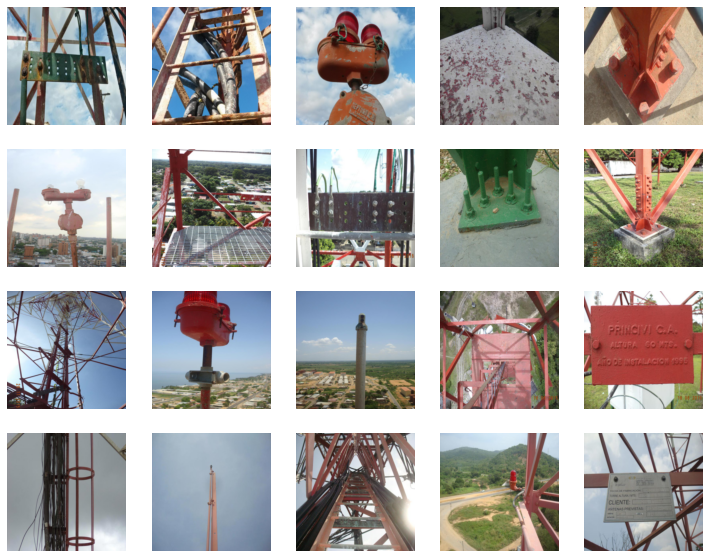

In [ ]:
show_images([item_tfms[0](Image.open(f)) for f in test_files], imsize=2.5)

In [ ]:
to_tensor = tvtfms.ToTensor()

def get_predictions(im_files:list, model:"torchvision.models"):
    tensor_images = []
    for file in im_files:
        tensor_images.append(item_tfms(to_tensor(Image.open(file)).cuda()))
        
    return model(torch.stack(tensor_images)).argmax(1)

print([int_to_label[pred.item()] for pred in get_predictions(test_files, loaded_model)])

['grounding_bar', 'ladder', 'light', 'platform', 'base_plate', 'light', 'platform', 'grounding_bar', 'base_plate', 'base_plate', 'ladder', 'light', 'lightning_rod', 'ladder', 'identification', 'ladder', 'lightning_rod', 'ladder', 'light', 'identification']


Almost all the images in the test set are predicted correctly. Thats ok for the purpuse of this post. But as said before, probably the approach would be to do a multi-label classification.

## Conclusions
- It was great to being able to train with more than 90% accuracy using PyTorch and miniai, starting with a pretrained resnet18 model.
- We implemented Confusion Matrix and Plot Top Losses from scratch, techniques available in fastai's Classification Interpretation.
- We also did batch inference in the GPU.